# Continous actions

In this notebook, we configure the agent actions to be continuos (linear) accelerations and train a policy using SAC and PPO.

You can skip training and instead load the last trained policy by changing the flag below.

In [1]:
from navground.learning.utils.jupyter import skip_if, run_if

training = True

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from navground import core, sim
from navground.learning import ControlActionConfig, DefaultObservationConfig
from stable_baselines3.common.monitor import Monitor
from navground.learning.examples.pad import get_env, marker, neighbor

name = "DummyContinuous"
action = ControlActionConfig(use_acceleration_action=True, max_acceleration=1, fix_orientation=True)
observation = DefaultObservationConfig(flat=False, include_velocity=True, include_target_direction=False)
sensors = [marker(), neighbor(max_speed=0)]
train_env = get_env(action=action, observation=observation, 
                sensors=sensors, start_in_opposite_sides=False, multi_agent=False)
test_env = get_env(action=action, observation=observation, 
               sensors=sensors, start_in_opposite_sides=True, multi_agent=False)
test_env = Monitor(test_env)

Observation contains the neighbor relative horizontal position, the relative horizontal position of the pad and the agent's own linear speed:

In [4]:
train_env.observation_space

Dict('neighbor/position': Box(-10.0, 10.0, (1, 1), float32), 'pad/x': Box(-1.0, 1.0, (1,), float32), 'ego_velocity': Box(-0.14, 0.14, (1,), float32))

The action contains just the linear accelerations:

In [5]:
train_env.action_space

Box(-1.0, 1.0, (1,), float32)

## SAC

We use single-agent SAC (off-policy RL algorithm) from StableBaseline3 to train the agent.

In [6]:
%%skip_if $training

import pathlib, os
from stable_baselines3 import SAC

sac_log = max(pathlib.Path(f'logs/{name}/SAC').glob('*'), key=os.path.getmtime)

In [7]:
%%run_if $training

from stable_baselines3 import SAC
from datetime import datetime as dt
from stable_baselines3.common.logger import configure
from navground.learning.utils.sb3 import callbacks
from navground.learning.scenarios.pad import render_kwargs

sac_model = SAC("MultiInputPolicy", train_env, verbose=0)
stamp = dt.now().strftime("%Y%m%d_%H%M%S")
sac_log = f"logs/{name}/SAC/{stamp}"
sac_model.set_logger(configure(sac_log, ["csv", "tensorboard"]))
cbs = callbacks(venv=test_env, best_model_save_path=sac_log, 
                eval_freq=2_000, export_to_onnx=True, **render_kwargs())
sac_log

'logs/DummyContinuous/SAC/20250521_083306'

In [8]:
%%run_if $training

sac_model.learn(total_timesteps=40_000, reset_num_timesteps=False, 
                log_interval=10, callback=cbs)
sac_model.num_timesteps

  0%|          | 0/40000 [00:00<?, ?it/s]

40000

In [9]:
from stable_baselines3.common.evaluation import evaluate_policy

best_sac_model = SAC.load(f'{sac_log}/best_model')
evaluate_policy(best_sac_model.policy, test_env, n_eval_episodes=30)

(-39.56168243333333, 22.911902901256326)

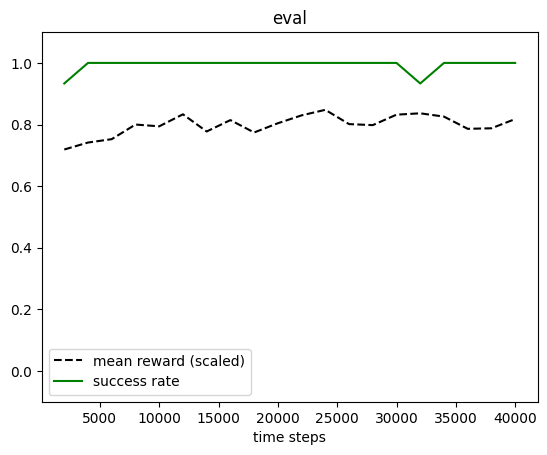

In [10]:
from navground.learning.utils.sb3 import plot_eval_logs

plot_eval_logs(sac_log, reward_low=-200, reward_high=0, success=True)

In [11]:
from navground.learning.evaluation.video import display_episode_video, record_episode_video

display_episode_video(test_env, policy=best_sac_model.policy, factor=4, seed=1, **render_kwargs())

In [12]:
from navground.sim.ui.video import record_video_from_run

record_episode_video(test_env, policy=best_sac_model.policy, 
                     path=f'../videos/{name}.mp4', seed=1, **render_kwargs())

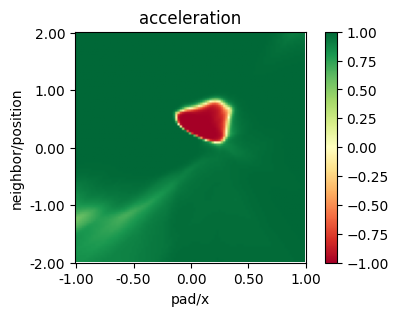

In [13]:
from navground.learning.utils.plot import plot_policy

plot_policy(best_sac_model.policy, 
            variable={'pad/x': (-1, 1), 'neighbor/position': (-2, 2)},
            fix={'ego_velocity': 0.0}, 
            actions={0: 'acceleration'}, width=5, height=3)

## PPO

We now use single-agent PPO (*on-policy* RL algorithm) from StableBaseline3 to train the agent.

In [14]:
%%skip_if $training

from stable_baselines3 import PPO

ppo_log = max(pathlib.Path(f'logs/{name}/PPO').glob('*'), key=os.path.getmtime)

In [15]:
%%run_if $training

from stable_baselines3 import PPO

ppo_model = PPO("MultiInputPolicy", train_env, verbose=0, n_steps=2048 * 3)
stamp = dt.now().strftime("%Y%m%d_%H%M%S")
ppo_log = f"logs/{name}/PPO/{stamp}"
ppo_model.set_logger(configure(ppo_log, ["csv", "tensorboard"]))
cbs = callbacks(venv=test_env, best_model_save_path=ppo_log, eval_freq=2048 * 6, **render_kwargs())
ppo_log

'logs/DummyContinuous/PPO/20250521_083912'

In [16]:
%%run_if $training

ppo_model.learn(total_timesteps=900_000, reset_num_timesteps=False, 
                log_interval=1, callback=cbs)
ppo_model.num_timesteps

  0%|          | 0/900000 [00:00<?, ?it/s]

903168

In [17]:
best_ppo_model = PPO.load(f'{ppo_log}/best_model')
evaluate_policy(best_ppo_model.policy, test_env, n_eval_episodes=30)

(-105.92672473333332, 81.27712064847142)

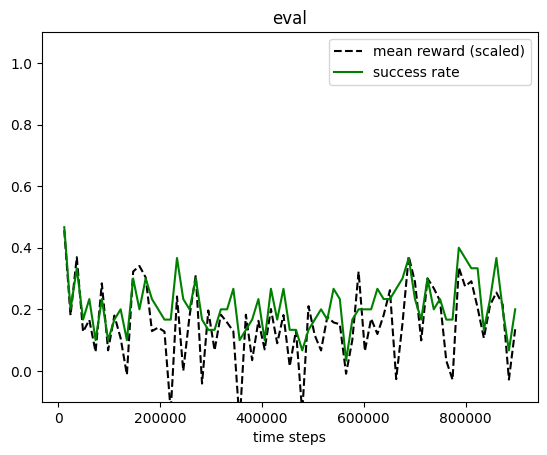

In [18]:
plot_eval_logs(ppo_log, reward_low=-200, reward_high=0, success=True)

In [19]:
display_episode_video(test_env, policy=best_ppo_model.policy, factor=4, seed=1, **render_kwargs())

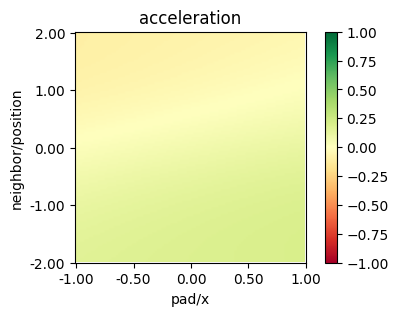

In [20]:
plot_policy(best_ppo_model.policy, 
            variable={'pad/x': (-1, 1), 'neighbor/position': (-2, 2)},
            fix={'ego_velocity': 0.07}, 
            actions={0: 'acceleration'}, width=5, height=3)

## PPO trained on starting from opposing sides

We have seen that PPO struggles to learn a good (safe) policy. This changes when it is trained with the agents starting from opposing sides.

In [21]:
%%skip_if $training

ppo_os_log = max(pathlib.Path(f'logs/{name}/PPO-OpposingSides').glob('*'), key=os.path.getmtime)

In [22]:
%%run_if $training

train_ppo_env = get_env(action=action, observation=observation, 
                sensors=sensors, start_in_opposite_sides=True, multi_agent=False)

ppo_os_model = PPO("MultiInputPolicy", train_ppo_env, verbose=0, n_steps=2048 * 3)
stamp = dt.now().strftime("%Y%m%d_%H%M%S")
ppo_os_log = f"logs/{name}/PPO-OpposingSides/{stamp}"
ppo_os_model.set_logger(configure(ppo_os_log, ["csv", "tensorboard"]))
cbs = callbacks(venv=test_env, best_model_save_path=ppo_os_log, eval_freq=2048 * 6)
ppo_os_log

'logs/DummyContinuous/PPO-OpposingSides/20250521_084713'

In [23]:
%%run_if $training

ppo_os_model.learn(total_timesteps=300_000, reset_num_timesteps=False, 
                   log_interval=1, callback=cbs)
ppo_os_model.num_timesteps

  0%|          | 0/300000 [00:00<?, ?it/s]

301056

In [24]:
best_ppo_os_model = PPO.load(f'{ppo_os_log}/best_model')
evaluate_policy(best_ppo_os_model.policy, test_env, n_eval_episodes=30)

(-30.980400666666664, 20.618880409527502)

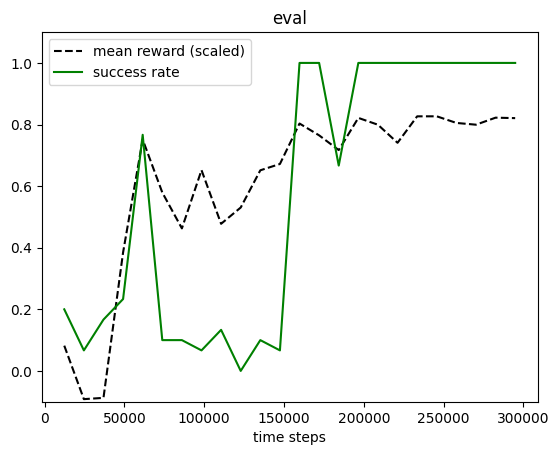

In [25]:
plot_eval_logs(ppo_os_log, reward_low=-200, reward_high=0, success=True)

In [26]:
display_episode_video(test_env, policy=best_ppo_os_model.policy, factor=4, seed=1, **render_kwargs())

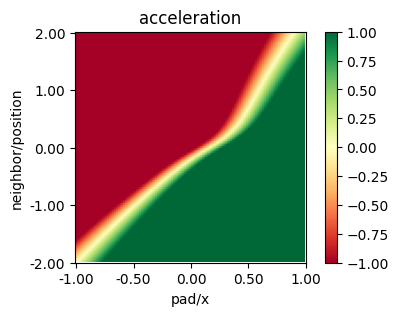

In [27]:
plot_policy(best_ppo_os_model.policy, 
            variable={'pad/x': (-1, 1), 'neighbor/position': (-2, 2)},
            fix={'ego_velocity': 0.07}, 
            actions={0: 'acceleration'}, width=5, height=3)